In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

download text file from: https://www.gutenberg.org/browse/scores/top

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Pride and Prejudice.txt to Pride and Prejudice.txt


In [3]:
file = open('Pride and Prejudice.txt','r', encoding= 'utf-8')

lines = []
for i in file :
  lines.append(i)

In [4]:
#lines

pre-process the data

In [5]:
#convert list to string

data = ""
for i in lines :
  data = ' '.join (lines)

In [6]:
#data

In [7]:
#replice unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces
data = data.split()
data = ' '.join(data)
data[:494]


'The Project Gutenberg eBook of Pride and Prejudice This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. '

In [8]:
len(data)

733690

Implement tokenization and make additional adjustments

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]
#len(sequence_data)

[1, 181, 390, 1000, 3, 298, 4, 946, 41, 1000, 23, 21, 1, 507, 3]

In [10]:
len(sequence_data)

131178

In [11]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7254


In [12]:
sequences = []

#we use 3words for predict next word (we have four words that 3words are input and the last word is output)
for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)

print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  131175


array([[   1,  181,  390, 1000],
       [ 181,  390, 1000,    3],
       [ 390, 1000,    3,  298],
       [1000,    3,  298,    4],
       [   3,  298,    4,  946],
       [ 298,    4,  946,   41],
       [   4,  946,   41, 1000],
       [ 946,   41, 1000,   23],
       [  41, 1000,   23,   21],
       [1000,   23,   21,    1]])

In [13]:
#input (the first three words)
X = []
#output(the last word)
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])

#convert to array
X = np.array(X)
y = np.array(y)
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[   1  181  390]
 [ 181  390 1000]
 [ 390 1000    3]
 [1000    3  298]
 [   3  298    4]
 [ 298    4  946]
 [   4  946   41]
 [ 946   41 1000]
 [  41 1000   23]
 [1000   23   21]]
Response:  [1000    3  298    4  946   41 1000   23   21    1]


In [14]:
#convert the output (y) to binary
y = to_categorical(y, num_classes=vocab_size)
y[:5]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

create of model

In [15]:
model = Sequential()
#Embeding layer get 3 argument(first argument is vocabulary size in my text data , second arument is output dimention(the size of word vector for each word is 10), third arument is input lenght)
model.add(Embedding(vocab_size, 10, input_length=3))
#LSTM layer (1000 units(output dimential space)) and return_sequences means the next layer is LSTM layer
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
#Dense layer (1000 units and activation function)
#relu activation function convert negative values to 0 and do nothing to positive values
model.add(Dense(1000, activation="relu"))
#another Dense layer that number of unit is vocab size because i want output from this vocabulary
#softmax activation function convert values to probability
model.add(Dense(vocab_size, activation="softmax"))

Plot the model

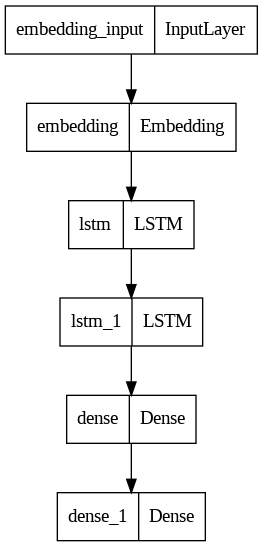

In [16]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model


keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

Train the model

In [17]:
#import Modelcheckpoint which use for save model and weight in iterabale
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=50, batch_size=64, callbacks=[checkpoint])

Epoch 1/50
2050/2050 [==============================] - ETA: 0s - loss: 6.2255
Epoch 1: loss improved from inf to 6.22551, saving model to next_words.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2050/2050 [==============================] - 43s 19ms/step - loss: 6.2255
Epoch 2/50
2050/2050 [==============================] - ETA: 0s - loss: 5.6048
Epoch 2: loss improved from 6.22551 to 5.60484, saving model to next_words.h5
2050/2050 [==============================] - 34s 17ms/step - loss: 5.6048
Epoch 3/50
2050/2050 [==============================] - ETA: 0s - loss: 5.2814
Epoch 3: loss improved from 5.60484 to 5.28136, saving model to next_words.h5
2050/2050 [==============================] - 34s 16ms/step - loss: 5.2814
Epoch 4/50
2047/2050 [============================>.] - ETA: 0s - loss: 5.0467
Epoch 4: loss improved from 5.28136 to 5.04647, saving model to next_words.h5
2050/2050 [==============================] - 35s 17ms/step - loss: 5.0465
Epoch 5/50
2050/2050 [==============================] - ETA: 0s - loss: 4.8442
Epoch 5: loss improved from 5.04647 to 4.84421, saving model to next_words.h5
2050/2050 [==============================] - 34s 17ms/step - loss: 4.8442
Ep

prediction

In [18]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

In [ ]:
def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""

  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break

  print(predicted_word)
  return predicted_word
while(True):
  text = input("Enter your line: ")

  if text == "0":
      print("Execution completed.....")
      break

  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)

          Predict_Next_Words(model, tokenizer, text)

      except Exception as e:
        print("Error occurred: ",e)
        continue


Enter your line: He was quite
['He', 'was', 'quite']
1/1 [==============================] - 1s 1s/step
young
Enter your line: and her sister
['and', 'her', 'sister']
1/1 [==============================] - 0s 18ms/step
scarcely
Enter your line: how can you abuse your own
['abuse', 'your', 'own']
1/1 [==============================] - 0s 18ms/step
children
